<a href="https://colab.research.google.com/github/leoa4238/AI-Project/blob/main/110_transferlearning_covid19_xray_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 전이 학습(Transfer Learning) : COVID-19를 흉부 X-ray로 탐지하기  
- 흉부 X-ray 이미지 분류: 세 가지 클래스 중 하나로 분류 - Normal, Viral Pneumonia, COVID-19 (정상, 바이러스성 폐렴, COVID-19)  

- 사전 학습된 ResNet18 모델을 불러와 마지막 Fully Connected (FC) 레이어를 수정하여 출력 클래스 수를 3개로 변경.

- 데이터셋: Kaggle의 COVID-19 Radiography Dataset (https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database) 사용

 --> COVID-19 양성 사례 3616장, 정상 10,192장, 폐 혼탁(비COVID 폐 감염) 6012장, 바이러스성 폐렴 1345장의 이미지와 해당 폐 마스크 포함.

In [ ]:
import os
import shutil
import random
import torch
import torchvision
from torchvision import datasets
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [ ]:
!gdown 1ql4oc0aAKL3Aw7q-6XwfD_ZaK9bPh9Wl -O covid.zip

Downloading...
From (original): https://drive.google.com/uc?id=1ql4oc0aAKL3Aw7q-6XwfD_ZaK9bPh9Wl
From (redirected): https://drive.google.com/uc?id=1ql4oc0aAKL3Aw7q-6XwfD_ZaK9bPh9Wl&confirm=t&uuid=02220c4b-2469-4879-915f-1be6f746e8e0
To: /content/covid.zip
100% 1.23G/1.23G [00:28<00:00, 44.0MB/s]


In [ ]:
!unzip -q covid.zip -d /content/

In [ ]:
data_dir = 'COVID-19 Radiography Database'
train_dir = os.path.join(data_dir, 'train')
val_dir  = os.path.join(data_dir, 'test')

print(os.listdir(data_dir))
print(os.listdir(train_dir))
print(os.listdir(val_dir))

['test', 'train']
['covid', 'normal', 'viral']
['covid', 'normal', 'viral']


In [ ]:
from torchvision.transforms import Compose, Resize, RandomHorizontalFlip, ToTensor, Normalize

# 학습용 데이터 변환 설정
train_transform = Compose([
    Resize(size=(224, 224)),  # 이미지 크기를 224x224로 리사이즈
    RandomHorizontalFlip(),  # 이미지를 랜덤으로 수평 뒤집기
    ToTensor(),                       # 이미지를 텐서 형식으로 변환 (값을 0~1 범위로 정규화)
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 각 채널별로 평균과 표준편차를 사용해 정규화
])

# 테스트용 데이터 변환 설정
test_transform = Compose([
    Resize(size=(224, 224)),   # 이미지 크기를 224x224로 리사이즈
    ToTensor(),                        # 이미지를 텐서 형식으로 변환
    Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # 학습 데이터와 동일한 평균과 표준편차로 정규화
])

### `datasets.ImageFolder(folder, transform)` data loader 생성

In [ ]:
# datasets.ImageFolder를 사용하여 훈련 데이터셋을 로드
# 이 함수는 주어진 디렉토리 경로에서 이미지 파일들을 자동으로 찾아서 레이블을 할당
# data_dir은 데이터가 저장된 루트 디렉토리
# 'train' 폴더 안에 있는 이미지들은 훈련을 위해 사용
train_data = datasets.ImageFolder(os.path.join(data_dir, 'train'), train_transform)

test_data = datasets.ImageFolder(os.path.join(data_dir, 'test'), test_transform)

In [ ]:
batch_size = 6  # 배치 크기 설정

# 학습 데이터 로더 생성
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)  # 학습 데이터 로더, 셔플 활성화

# 테스트 데이터 로더 생성
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)  # 테스트 데이터 로더, 셔플 활성화

# 학습 및 테스트 배치 수 출력
print('Number of training batches', len(train_loader))  # 학습 데이터 배치 개수 출력
print('Number of test batches', len(test_loader))  # 테스트 데이터 배치 개수 출력

Number of training batches 470
Number of test batches 15


## 데이터 시각화

In [ ]:
# 클래스 이름 가져오기 (정상, 바이러스성 폐렴, COVID-19)
class_names = train_data.classes
class_names

['covid', 'normal', 'viral']

In [ ]:
# 이미지를 보여주는 함수 정의
def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))  # 그래프 크기 설정

    # 각 이미지를 순회하며 표시
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])  # 1행 6열로 이미지 표시, x축과 y축 눈금 제거
        image = image.numpy().transpose((1, 2, 0))  # 텐서를 (H, W, C) 형식으로 변환하여 표시

        # 정규화 해제를 위한 평균 및 표준편차 설정
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean  # 정규화 해제
        image = np.clip(image, 0., 1.)  # 이미지 값을 0과 1 사이로 클리핑

        plt.imshow(image)  # 이미지 표시

        # 예측이 틀린 경우 레이블 색상을 빨간색으로 설정
        col = 'green'
        if preds[i] != labels[i]:  # 예측이 실제 레이블과 다르면 빨간색 설정
            col = 'red'

        # 실제 클래스 레이블과 예측 클래스 레이블 표시
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')  # 실제 클래스 레이블
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)  # 예측 클래스 레이블, 색상 지정

    plt.tight_layout()  # 레이아웃 간격 조정
    plt.show()  # 그래프 표시

torch.Size([6, 3, 224, 224]) torch.Size([6])


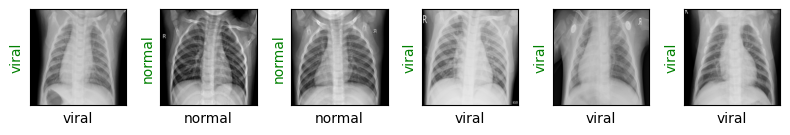

In [ ]:
# 학습 데이터 로더에서 첫 번째 배치의 이미지와 레이블을 가져옴
images, labels = next(iter(train_loader))
print(images.shape, labels.shape)

# 이미지와 실제 레이블을 사용하여 이미지 표시 함수 호출 (예측 값은 실제 레이블로 설정)
show_images(images, labels, labels)  # show_images 함수는 실제 레이블을 예측 레이블로 사용하여 이미지 표시

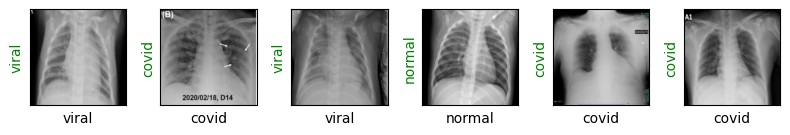

In [ ]:
images, labels = next(iter(test_loader))

show_images(images, labels, labels)

## Model 생성

In [ ]:
resnet18 = torchvision.models.resnet18(pretrained=True)  # 사전 학습된 ResNet18 모델 로드

print(resnet18)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 165MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# ResNet18 모델의 최종 완전 연결(FC) 레이어를 수정하여 출력 클래스 수를 3으로 설정 (normal, viral, covid)
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)

resnet18.to(device)

# 손실 함수로 교차 엔트로피 손실 설정
loss_fn = torch.nn.CrossEntropyLoss()

# Adam 옵티마이저 설정, 학습률은 3e-5로 설정
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

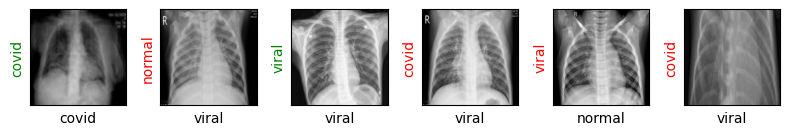

In [ ]:
# 예측 결과를 시각화하는 함수 정의
def show_preds():
    resnet18.eval()  # 모델을 평가 모드로 설정

    images, labels = next(iter(test_loader))  # 테스트 데이터 로더에서 첫 번째 배치의 이미지와 레이블 가져오기
    images = images.to(device)  # 이미지를 GPU로 이동

    outputs = resnet18(images)  # 모델을 사용하여 예측 결과 생성
    _, preds = torch.max(outputs, 1)  # 예측 결과 중 가장 높은 확률을 가진 클래스 인덱스 선택

    show_images(images.cpu(), labels, preds.cpu())  # 실제 레이블과 예측 레이블을 사용하여 이미지 표시

# 예측 결과 시각화 함수 호출
show_preds()

## Model 학습

학습 시작 ..........
에포크 1/1 시작
Step 0에서 검증 수행 중...
Validation Loss: 1.1189, Accuracy: 0.3556


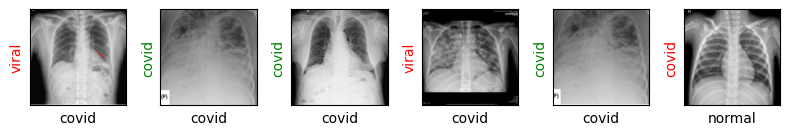

Step 20에서 검증 수행 중...
Validation Loss: 0.9315, Accuracy: 0.4889


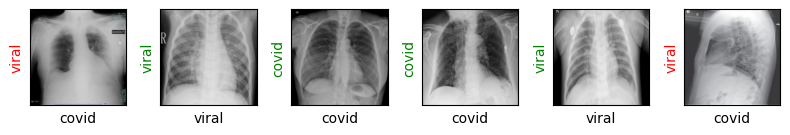

Step 40에서 검증 수행 중...
Validation Loss: 0.5904, Accuracy: 0.8333


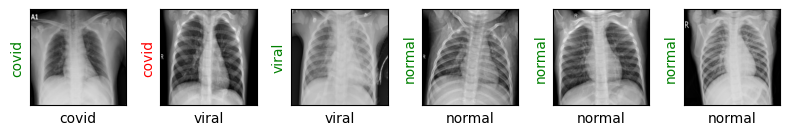

Step 60에서 검증 수행 중...
Validation Loss: 0.4357, Accuracy: 0.9000


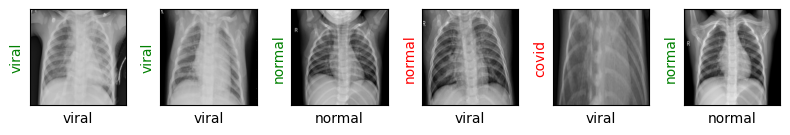

Step 80에서 검증 수행 중...
Validation Loss: 0.3687, Accuracy: 0.9333


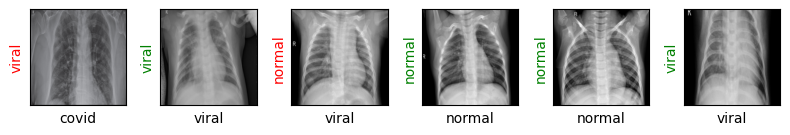

Step 100에서 검증 수행 중...
Validation Loss: 0.2738, Accuracy: 0.9333


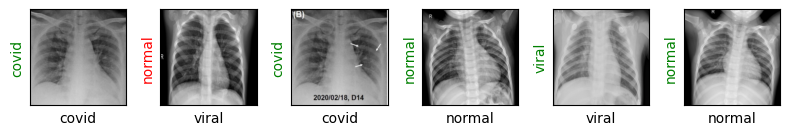

Step 120에서 검증 수행 중...
Validation Loss: 0.2567, Accuracy: 0.9222


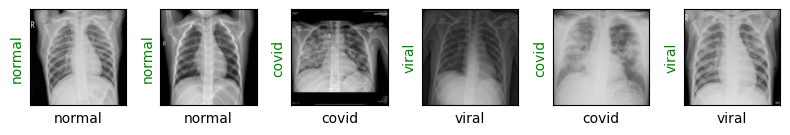

Step 140에서 검증 수행 중...
Validation Loss: 0.2530, Accuracy: 0.9111


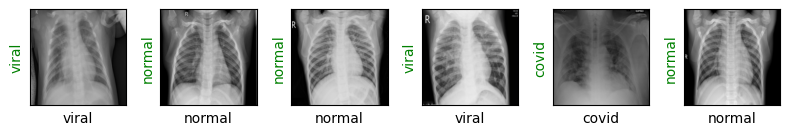

Step 160에서 검증 수행 중...
Validation Loss: 0.2142, Accuracy: 0.9333


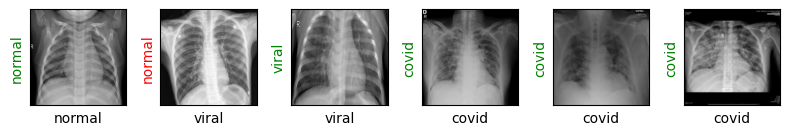

Step 180에서 검증 수행 중...
Validation Loss: 0.2172, Accuracy: 0.9444


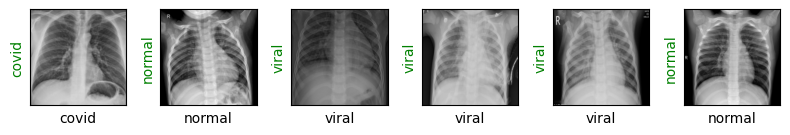

Step 200에서 검증 수행 중...
Validation Loss: 0.1562, Accuracy: 0.9444


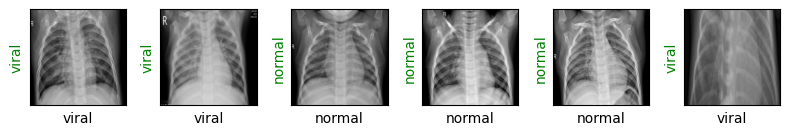

Step 220에서 검증 수행 중...
Validation Loss: 0.1761, Accuracy: 0.9556


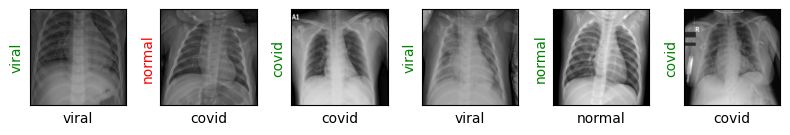

성능 기준 충족으로 조기 종료....
Training Loss: 0.3624
✅ 학습 완료.


In [ ]:
epochs = 1  # 전체 학습 반복 횟수
early_stop = False  # 조기 종료 플래그

print('학습 시작 ..........')

for epoch in range(epochs):
    print('=' * 20)
    print(f'에포크 {epoch + 1}/{epochs} 시작')
    print('=' * 20)

    train_loss = 0.0
    resnet18.train()  # 모델을 학습 모드로 설정

    # 학습 데이터 반복
    for step, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = resnet18(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # 일정 스텝마다 검증 수행
        if step % 20 == 0:
            print(f'Step {step}에서 검증 수행 중...')

            resnet18.eval()
            val_loss = 0.0
            correct = 0

            with torch.inference_mode():
                for val_step, (images, labels) in enumerate(test_loader):
                    images = images.to(device)
                    labels = labels.to(device)

                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    correct += (preds == labels).sum().item()

            val_loss /= (val_step + 1)
            accuracy = correct / len(test_loader.dataset)

            print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')
            show_preds()
            resnet18.train()       # 다시 학습 모드로 전환

            # 조기 종료 조건 확인
            if accuracy >= 0.95:
                print('성능 기준 충족으로 조기 종료....')
                early_stop = True
                break           # inner loop 탈출

    train_loss /= (step + 1)
    print(f'Training Loss: {train_loss:.4f}')

    if early_stop:
        break         #  outer loop 탈출

print('✅ 학습 완료.')

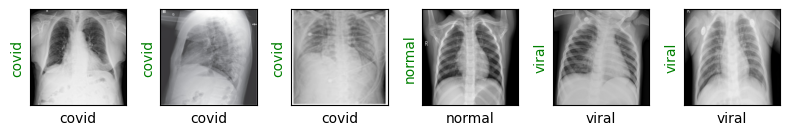

In [ ]:
show_preds()